# Problem Set 3
Designed by Sarah Adel Bargal, Ben Usman, and Kun He, with help from Kate Saenko and Brian Kulis.

This assignment will introduce you to:
- building, training, and testing of neural networks in TensorFlow
- using TensorFlow on the SCC cluster
- extracting and visualizing neural network features

Note: For programming, the use of any additional abstraction of TensorFlow (like `Keras` and `tf.contrib.learn`) is **not permitted**.

## Part 0: Tutorials
The contents of these tutorials are helpful for solving this assignment and upcoming assignments. Please be sure to go through them before proceeding.
1. [MNIST For ML Beginners](https://www.tensorflow.org/versions/r0.10/tutorials/mnist/beginners/)
2. [Deep MNIST for Experts](https://www.tensorflow.org/versions/r0.10/tutorials/mnist/pros/)
3. [TensorFlow Mechanics 101](https://www.tensorflow.org/versions/r0.10/tutorials/mnist/tf/)
4. [Sharing Variables](https://www.tensorflow.org/programmers_guide/variable_scope)

## Part 1: MNIST Softmax Classifier Demo in TensorFlow

TensorFlow is already installed on the SCC. Please review the instructions on [connecting to SCC](https://docs.google.com/document/d/1C4XrrTZIRfmJ6-LHmuJ4levTnunezujVrxCz8jJ4rec), and [running jobs on SCC](http://www.bu.edu/tech/support/research/system-usage/running-jobs/).

Make sure you are capable of running this demo (using `qsub`) on the SCC cluster: [`mnist_softmax_scope.py`](https://github.com/kunhe/cs591s2/blob/master/mnist_softmax_scope.py). There is no required deliverable, but this exercise is helpful for running jobs on the SCC in the future.

The demo is another implementation of `mnist_softmax.py` presented in the MNIST for ML Beginners tutorial, but using scopes. For the purposes of this assignment, the contents of the demo is also replicated below.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
from matplotlib import pyplot as plt
import pickle
from sklearn.manifold import TSNE
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def logistic_regression(x_):
    tf.set_random_seed(2)
    scope_args = {'initializer': tf.random_normal_initializer(stddev=1e-4)}
    with tf.variable_scope("weights", **scope_args):
        W = tf.get_variable('W', shape=[784, 10])
        b = tf.get_variable('b', shape=[10])
        y_logits = tf.matmul(x_, W) + b
    return y_logits


def test_classification(model_function, learning_rate=0.1):
    mnist = input_data.read_data_sets('./datasets/mnist/', one_hot=True)

    with tf.Graph().as_default() as g:
        tf.set_random_seed(2)
        with tf.device("/gpu:0"):
            x_ = tf.placeholder(tf.float32, [None, 784])
            y_ = tf.placeholder(tf.float32, [None, 10])
            y_logits = model_function(x_)
            
            losses = tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_logits)
            cross_entropy_loss = tf.reduce_mean(losses)
            train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy_loss)
            
            y_pred = tf.argmax(tf.nn.softmax(y_logits), dimension=1)
            correct_prediction = tf.equal(y_pred, tf.argmax(y_, 1))
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    with g.as_default(), tf.Session() as sess:
        tf.set_random_seed(2)
        sess.run(tf.global_variables_initializer())
        
        for iter_i in range(20001):
            batch_xs, batch_ys = mnist.train.next_batch(100)
            sess.run(train_step, feed_dict={x_: batch_xs, y_: batch_ys})
            
            if iter_i % 5000 == 0:
                tf_feed_dict = {x_: mnist.test.images, y_: mnist.test.labels}
                acc_value = sess.run(accuracy, feed_dict=tf_feed_dict)
                print('iteration %d\t accuracy: %.3f'%(iter_i, acc_value))

In [3]:
test_classification(logistic_regression, learning_rate=0.1)

Extracting ./datasets/mnist/train-images-idx3-ubyte.gz
Extracting ./datasets/mnist/train-labels-idx1-ubyte.gz
Extracting ./datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting ./datasets/mnist/t10k-labels-idx1-ubyte.gz
iteration 0	 accuracy: 0.407
iteration 5000	 accuracy: 0.921
iteration 10000	 accuracy: 0.922
iteration 15000	 accuracy: 0.925
iteration 20000	 accuracy: 0.924


## Part 2: Building Neural Networks in TensorFlow

(45 points)

### Q2.1 MLP in TensorFlow

Task: 

- Implement a multi-layer perceptron function **`mlp(x, hidden_sizes, activation_fn)`** in TensorFlow that has the following input and output: 

 **Inputs**
 - `x`, an input tensor of the images in the current batch `[batch_size, 28x28]`
 - `hidden_sizes`, a list of the number of hidden units per layer. For example: `[5,2]` means  5 hidden units in the first layer, and 2 hidden units in the second (output) layer.
 (Note: for MNIST, we need `hidden_sizes[-1]==10` since it has 10 classes.)
 - `activation_fn`, the activation function to be applied

 **Output**
 - a tensor of shape `[batch_size, hidden_sizes[-1]]`. 

**Note: ** 
- Make sure the activation function is not applied to the final (output) layer.
- It is recommended to use scopes and `tf.get_variable()` (as opposed to `tf.Variable()` which you may see elsewhere), as demonstrated in the sample code, and explained in the "Sharing Variables" tutorial in Part 0. Also see [here](http://stackoverflow.com/questions/37098546/difference-between-variable-and-get-variable-in-tensorflow).

The following code tests your  implementation of the **`mlp()`** function. It basically recreates the 2-layer MLP with ReLU activation that you implemented in Problem Set 2. It should give an accuracy of above 0.97.

In [3]:
def relu(x, alpha, max_value=None): # implement leaky relu along with standard relu for question 3
    if alpha != 0.:
        negative_part = tf.nn.relu(-x)
    x = tf.nn.relu(x)
    if max_value is not None:
        max_value = _to_tensor(max_value, x.dtype.base_dtype)
        zero = _to_tensor(0., x.dtype.base_dtype)
        x = tf.clip_by_value(x, zero, max_value)
    if alpha != 0.:
        alpha = _to_tensor(alpha, x.dtype.base_dtype)
        x -= alpha * negative_part
    return x

def _to_tensor(x, dtype): # part of leaky relu implementation
    x = tf.convert_to_tensor(x)
    if x.dtype != dtype:
        x = tf.cast(x, dtype)
    return x

def mlp(x, hidden_sizes, keep_prob=1, alpha=0, activation_fn=relu):
    with tf.variable_scope("weights"):
        tf.set_random_seed(2)
        n_lays = len(hidden_sizes)
        Ws = dict()
        bs = dict()
        hiddens = dict()
        '''
        I cannot make this work:
        >> with tf.variable_scope("foo"):
        >>     with tf.variable_scope("bar"):
        >>         v = tf.get_variable("v", [1])
        >> assert v.name == "foo/bar/v:0"
        So i used the naive way to assign name to variables
        ''' 
        Ws['1'] = tf.get_variable('1'+str(0),
                                   shape=[784, hidden_sizes[0]], 
                                   initializer=tf.random_uniform_initializer(minval=-6*np.sqrt(1.0/(784 + hidden_sizes[0])), 
                                                                             maxval=6*np.sqrt(1.0/(784 + hidden_sizes[0]))
                                                                            , seed=21))
        bs['1'] = tf.get_variable('1'+str(1),
                                   shape=[hidden_sizes[0]],
                                   initializer = tf.truncated_normal_initializer(mean=0.3, stddev=1e-4))
        if activation_fn == relu:
            hiddens['1'] = activation_fn(tf.matmul(x, Ws['1']) + bs['1'], alpha)
        else: hiddens['1'] = activation_fn(tf.matmul(x, Ws['1']) + bs['1'])
        hiddens['1'] = tf.nn.dropout(hiddens['1'], keep_prob, seed=2) # apply dropout for question 3
        
        if n_lays > 2:
            for i in range(2, n_lays):
                Ws[str(i)] = tf.get_variable(str(i)+str(0),
                                                      shape=[hidden_sizes[i-2], hidden_sizes[i-1]], 
                                                      initializer=tf.random_uniform_initializer( \
                                                                minval=-6*np.sqrt(1.0/(hidden_sizes[i-2] + hidden_sizes[i-1])), 
                                                                maxval=6*np.sqrt(1.0/(hidden_sizes[i-2] + hidden_sizes[i-1]))
                                                                , seed=21))
                bs[str(i)] = tf.get_variable(str(i)+str(1),
                                                      shape=[hidden_sizes[i-1]],
                                                      initializer = tf.truncated_normal_initializer( \
                                                                                            mean=0.3, stddev=1e-4))
                if activation_fn == relu:
                    hiddens[str(i)] = activation_fn(tf.matmul(hiddens[str(i-1)], 
                                                                   Ws[str(i)]) + bs[str(i)], alpha)
                else: hiddens[str(i)] = activation_fn(tf.matmul(hiddens[str(i-1)], 
                                                                   Ws[str(i)]) + bs[str(i)])
        
        Ws[str(n_lays)] = tf.get_variable(str(n_lays)+str(0), 
                                                   shape=[hidden_sizes[-2], hidden_sizes[-1]], 
                                                   initializer=tf.random_uniform_initializer( \
                                                                 minval=-6*np.sqrt(1.0/(hidden_sizes[-2] + hidden_sizes[-1])), 
                                                                 maxval=6*np.sqrt(1.0/(hidden_sizes[-2] + hidden_sizes[-1]))
                                                                 , seed=21))
        bs[str(n_lays)] = tf.get_variable(str(n_lays)+str(1), 
                                                   shape=[hidden_sizes[-1]],
                                                   initializer=tf.truncated_normal_initializer(mean=0.3, stddev=1e-4))
        y_logits = tf.matmul(hiddens[str(n_lays-1)], Ws[str(n_lays)]) + bs[str(n_lays)]
        
    return y_logits, Ws # Extract Ws for L2 regularization in question 3

In [4]:
test_classification(lambda x: mlp(x, [64, 10])[0], learning_rate=0.1)

Extracting ./datasets/mnist/train-images-idx3-ubyte.gz
Extracting ./datasets/mnist/train-labels-idx1-ubyte.gz
Extracting ./datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting ./datasets/mnist/t10k-labels-idx1-ubyte.gz
iteration 0	 accuracy: 0.196
iteration 5000	 accuracy: 0.966
iteration 10000	 accuracy: 0.972
iteration 15000	 accuracy: 0.976
iteration 20000	 accuracy: 0.975


### Q2.2 Siamese Network
A siamese network is a network having two identical subnetworks that share parameters. A siamese network gives a *similarity metric* between pairs of inputs, which __assigns high values to similar pairs and low values to dissimilar pairs__. In MNIST, we can construct similar pairs by taking images from the same digit class, and dissimilar pairs from images from different classes. 


A sample Siamese network is presented below [Koch et al., Siamese Neural Networks for One-shot Image Recognition, ICML 2015]. Note how the two subnetworks have identical parameters:

<img src="siamese.png" style="width:320px;">


Given a Siamese network, we can determine the similarity between inputs $x_1$ and $x_2$, by taking the sign of the cosine similarity $\frac{\langle r_1,r_2\rangle}{\|r_1\|\|r_2\|}$, where $r_1$ and $r_2$ are the hidden representations produced by the network for $x_1$ and $x_2$, respectively. 

Tasks:

1. Build a Siamese Network in TensorFlow that receives as input two MNIST images, and decides whether they belong to the same digit category. Each subnetwork is an MLP with 2 hidden layers with 64 units, __followed by a "distance layer" with 32 units__. They will be created using the **`mlp()`** function you implemented earlier, using input argument `hidden_sizes=[64,64,32]`. The network computes the __cosine similarity__, as defined above, __in the final output layer__.

2. Train and test this model, and  report your test accuracy for this task.

You will need to implement the following two functions.

In [8]:
def cosine_similarity(x_repr1, x_repr2):
#     return tf.sqrt( tf.reduce_sum(tf.square(tf.subtract(x_repr1, x_repr2)),reduction_indices=1)) # L2 norm
#     return tf.reduce_sum(tf.abs(tf.subtract(x_repr1, x_repr2)),reduction_indices=1) # L1 norm
    return tf.reduce_sum(tf.multiply(tf.nn.l2_normalize(x_repr1,1),tf.nn.l2_normalize(x_repr2,1)),reduction_indices=1)

def build_model(mlp_args):
    with tf.Graph().as_default() as g:
        tf.set_random_seed(2)
        with tf.device("/gpu:0"):
            x1 = tf.placeholder(tf.float32, [None, 784])
            x2 = tf.placeholder(tf.float32, [None, 784])
            y = tf.placeholder(tf.float32, [None])
            keep_prob = tf.placeholder(tf.float32)

            with tf.variable_scope("siamese") as var_scope:
                tf.set_random_seed(2)
                x_repr1,_ = mlp(x1, mlp_args, keep_prob)
                var_scope.reuse_variables()
                x_repr2,_ = mlp(x2, mlp_args, keep_prob)
                logits = cosine_similarity(x_repr1, x_repr2)
                # Squaching cosine similarity with Sigmoid function, then optimizer cross entropy
                loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits, name='SigmoidwithCE'))
                # Squaching prediction from {-1,1} to {0,1}
                y_pred = tf.add(tf.divide(tf.sign(logits,name='y_pred'),2),0.5)
                accuracy = tf.reduce_mean(tf.cast(tf.equal(y_pred, y), tf.float32), name='accuracy')       
    return {'graph': g, 'inputs': [x1, x2, y, keep_prob], 'pred': y_pred, 'logits': logits, 
            'loss': loss, 'accuracy': accuracy, 'x_repr1': x_repr1, 'x_repr2': x_repr2}

# data preparation
def mnist_siamese_dataset_iterator(batch_size, dataset_name):
    mnist = input_data.read_data_sets('./datasets/mnist/', one_hot=True)
    dataset = getattr(mnist, dataset_name)
    
    while True:
        if batch_size > 0:
            X1, y1 = dataset.next_batch(batch_size)
            X2, y2 = dataset.next_batch(batch_size)
            y = np.argmax(y1, axis=1) == np.argmax(y2, axis=1)
            yield X1, X2, y.astype(int)
        else:
            X1 = dataset.images
            idx = np.arange(len(X1))
            np.random.seed(2)
            np.random.shuffle(idx)
            X2 = X1[idx]
            y1 = dataset.labels
            y2 = y1[idx]
            y = np.argmax(y1, axis=1) == np.argmax(y2, axis=1)
            yield X1, X2, y.astype(int), y1
            
try:
    from itertools import izip as zip
except: None
    
def run_training_SGD21(model_dict, train_data_iterator, test_full_iter, 
                 train_full_iter, keep_prob=1, n_iter=1001, print_every=100, learning_rate = 0.1):
    with model_dict['graph'].as_default():
        tf.set_random_seed(2)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        train_op = optimizer.minimize(model_dict['loss'])
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
#             writer = tf.summary.FileWriter('./graph/', graph=tf.get_default_graph())
            # type >>tensorboard --logdir=./graph --port 6006<< to plot graph
            
            for iter_i, data_batch in zip(range(n_iter), train_data_iterator):
                batch_feed_dict = dict(zip(model_dict['inputs'][:3], data_batch))
                batch_feed_dict[model_dict['inputs'][3]] = keep_prob # implement dropout
                _,batch_acc,batch_loss = sess.run([train_op,model_dict['accuracy'], model_dict['loss']], \
                                                  feed_dict=batch_feed_dict)
                
                if iter_i % print_every == 0:
#                     print('Batch accuracy is %.3f, and batch loss is %.3f'%(batch_acc,batch_loss))
                    print_zip_iter = zip([train_full_iter, test_full_iter], ['train', 'test'])
                    for data_iterator, data_name in print_zip_iter:
                        test_batch = next(data_iterator)
                        batch_feed_dict = dict(zip(model_dict['inputs'], test_batch))
                        batch_feed_dict[model_dict['inputs'][3]] = 1 # turnoff dropout for testing
                        to_compute = [model_dict['accuracy'], model_dict['loss'], model_dict['x_repr1']]
                        acc_value, loss_val, x1 = sess.run(to_compute, batch_feed_dict)
                        fmt = (iter_i, acc_value, loss_val)
                        print(data_name, 'iteration %d\t accuracy: %.3f, loss: %.3f'%fmt)
                        
# form training and testing sets
train_data_iterator = mnist_siamese_dataset_iterator(100, 'train')
test_full_iter = mnist_siamese_dataset_iterator(-1, 'test')
train_full_iter = mnist_siamese_dataset_iterator(-1, 'train')

In [9]:
mlp_args = [64, 64, 32]
model = build_model(mlp_args)
run_training_SGD21(model, train_data_iterator, test_full_iter, train_full_iter)

Extracting ./datasets/mnist/train-images-idx3-ubyte.gz
Extracting ./datasets/mnist/train-labels-idx1-ubyte.gz
Extracting ./datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting ./datasets/mnist/t10k-labels-idx1-ubyte.gz
Extracting ./datasets/mnist/train-images-idx3-ubyte.gz
Extracting ./datasets/mnist/train-labels-idx1-ubyte.gz
Extracting ./datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting ./datasets/mnist/t10k-labels-idx1-ubyte.gz
train iteration 0	 accuracy: 0.101, loss: 1.068
Extracting ./datasets/mnist/train-images-idx3-ubyte.gz
Extracting ./datasets/mnist/train-labels-idx1-ubyte.gz
Extracting ./datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting ./datasets/mnist/t10k-labels-idx1-ubyte.gz
test iteration 0	 accuracy: 0.097, loss: 1.074
train iteration 100	 accuracy: 0.566, loss: 0.683
test iteration 100	 accuracy: 0.557, loss: 0.685
train iteration 200	 accuracy: 0.585, loss: 0.676
test iteration 200	 accuracy: 0.575, loss: 0.680
train iteration 300	 accuracy: 0.600, loss: 0.671
tes

## Part 3: Model Variants

(30 points)

# 3.1. Hyper parameters

## 3.1.1 Distance function
The first alternative model I thought of was __replace cosine similarity with L1 and L2 distance function__, but they either return terrible results with normalization or return NaN without normalization. My analysis is that without CNN, the network's output is not normalized to give the true distance of two images.

On the other hand, the cosine similarity's output is btw -1 and 1, hence the sigmoid will only has value btw 0.3 and 0.7. Therefore, I will try to __multiplying cosine similarity with a few scaling coefficient__ to try to overcome this issue.

## 3.1.2 Cost function
Since this is a binary classfication problem, I will stick with cross entropy wiht modification on logits output.

## 3.1.3 Regularization
Since both training and test data are from the same dataset, I think I should use regularization to prevent overfitting. To be more specific, I will try out __L2 regularization and early stopping__.

__Dropout__ will also be used for very deep architetures to prevent overfitting.

__Number of iteration__ is also considered an important factor of over/underfitting, which is also part of early stopping strategy as well.

## 3.1.4 Optimizer
I think __Adam and RMS optimizer__ are both worth testing out with some of optimizar parameters, Both of them will .

__Learning rate__ is obviously a key parameter for this model.

__Batch normalization will be excluded__ since we are not allowed to use tf.contrib and the model is fairly quick to train.

## 3.1.5 Architecture
Varies combination of __depth and width of the MLP__ will be tested.

## 3.1.6 Activation function 
Apart from __relu, leaky relu, tanh and sigmoid__ will also be tested, since they are the three most common activation functions to use.

## 3.1.7 Initialization
I think the model is quite sensitive to normalization judging by its behaviour I observed from question two. So I will test them as well.

## 3.1.8 Batch size
I will also only manually testing on this parameter.


# 3.2. Parameter optimization

## 3.2.1 Search method
__Most of the randomness is removed by fixing seed.__

Since their are eight hyperparameters, I will use __line search__ Since there are eight parameters. 

I will also __start with the most sensitive parameters__ to the least.

## 3.2.2 Confident interval (bias and variance)
I will __repeat each model five times__ and taking the average to make sure I don't have biased test result. This is still not optimal, but I also cannot running them too many times. In practice, I would like to run each test ten time and taking bias and variance into account.

## 3.2.3 Bench marking
I will use the result from Question 2.2 as bench mark.

In [5]:
def my_build_model(mlp_args, alpha=0, activation=relu, regularizing_rate=0, scale=1):
    with tf.Graph().as_default() as g:
        tf.set_random_seed(2)
        with tf.device("/gpu:0"):
            x1 = tf.placeholder(tf.float32, [None, 784])
            x2 = tf.placeholder(tf.float32, [None, 784])
            y = tf.placeholder(tf.float32, [None])
            keep_prob = tf.placeholder(tf.float32)
            with tf.variable_scope("siamese") as var_scope:
                tf.set_random_seed(2)
                # Add option for different activation and drop out
                x_repr1,_ = mlp(x1, mlp_args, keep_prob, alpha, activation)
                var_scope.reuse_variables()
                x_repr2,Ws = mlp(x2, mlp_args, keep_prob, alpha, activation)
                logits = cosine_similarity(x_repr1, x_repr2)
                # Apply L2 regularization
                reg = tf.zeros([1,1])
                for _, item in Ws.items():
                    reg += regularizing_rate*tf.nn.l2_loss(item)
                # scaling logits
                loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits*scale), name='SigCE')
                y_pred = tf.add(tf.divide(tf.sign(logits,name='y_pred'),2),0.5)
                accuracy = tf.reduce_mean(tf.cast(tf.equal(y_pred, y), tf.float32), name='accuracy')
    return {'graph': g, 'inputs': [x1, x2, y, keep_prob], 'pred': y_pred, 'logits': logits,
            'loss': loss, 'accuracy': accuracy, 'reg':reg, 'x_repr1':x_repr1}

def print_all(n_iter, acc_train, loss_train, acc_test, loss_test):
    fig,axe = plt.subplots(1,2,figsize=(10,4))
    n1 = len(loss_train)*100
    n2 = len(loss_test)*100
    axe[0].plot(np.arange(0,n1,100),acc_train,label='Train')
    axe[0].plot(np.arange(0,n2,100),acc_test,label='Test')
    axe[0].set_ylim(0.94,1)
    axe[0].legend(loc='best')
    axe[0].set_title('Accuracy')
    axe[0].set_xlabel('Iterations')
    axe[1].plot(np.arange(0,n1,100),loss_train,label='Train')
    axe[1].plot(np.arange(0,n2,100),loss_test,label='Test')
    axe[1].set_ylim(0.40,0.55)
    axe[1].set_title('Loss')
    axe[1].set_xlabel('Iterations')
    plt.show()

def run_training_3(to_print, model_dict, opt, epsilon, train_data_iterator, test_full_iter, train_full_iter, \
                   keep_prob, n_iter=1001, learning_rate = 0.1):
    with model_dict['graph'].as_default():
        tf.set_random_seed(2)
        # SGD, RMS and Adam optimizer
        if opt == 'RMS':
            optimizer = tf.train.RMSPropOptimizer(learning_rate, epsilon=epsilon, decay=0.99, momentum=0.9)
        elif opt == 'Adam':  optimizer = tf.train.AdamOptimizer(learning_rate, epsilon=epsilon, beta1=0.9, beta2=0.99)
        else: optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        
        train_op = optimizer.minimize(model_dict['loss']+model_dict['reg']) # L2 regularization
        with tf.Session() as sess:
            tf.set_random_seed(2)
            sess.run(tf.global_variables_initializer())
            acc_train=[]; loss_train=[]; acc_test=[]; loss_test=[]; flag = True; loss_log_test = 100000; count = 0
            for iter_i, data_batch in zip(range(n_iter), train_data_iterator):
                if flag == True:
                    batch_feed_dict = dict(zip(model_dict['inputs'], data_batch))
                    batch_feed_dict[model_dict['inputs'][3]] = keep_prob # implement dropout
                    sess.run(train_op, feed_dict=batch_feed_dict)

                    if iter_i % 100 == 0:
                        print_zip_iter = zip([train_full_iter, test_full_iter], ['train', 'test'])
                        for data_iterator, data_name in print_zip_iter:
                            test_batch = next(data_iterator)
                            batch_feed_dict = dict(zip(model_dict['inputs'], test_batch))
                            batch_feed_dict[model_dict['inputs'][3]] = 1 # turnoff dropout for testing
                            to_compute = [model_dict['accuracy'], model_dict['loss'], model_dict['x_repr1']]
                            acc_value, loss_val, x1 = sess.run(to_compute, batch_feed_dict)
                            fmt = (iter_i, acc_value, loss_val)
                            if data_name == 'test':
                                # Add early stopping    
                                if loss_val > loss_log_test:
                                    if count >= 3: # patience is set to 300 iterations
                                        print('Early stopping!')
                                        flag = False
                                    else: 
                                        count += 1; loss_log_test = loss_val
                                        acc_test.append(acc_value); loss_test.append(loss_val)
                                else: 
                                    acc_test.append(acc_value); loss_test.append(loss_val)
                                    loss_log_test = loss_val
                                    count = 0 # reset counter
                            else: acc_train.append(acc_value); loss_train.append(loss_val)
                else: break
            pickle.dump(x1,open('x_test.p','wb'))                
            pickle.dump(test_batch[3],open('y_test.p','wb'))
            if to_print: # print acc and loss on command
                print_all(n_iter, acc_train, loss_train, acc_test, loss_test)
                
    return acc_test[-1], loss_test[-1] 

'''
Hyperparameters:
param['archtecture']: network depth and width
param['activation'], param['alpha']: hidden layer's activation function, alpha used for leaky relu
param['reg_coef']: penalty strength for L2 regularization
param['logits_scaler']: scaler for logits
param['optmizer'], param['epsilon']: choice of SGD, RMS and Adam optimizer, and epsilon's value
param['dropout']: percentage of neurons used for running network
param['n_iter']: number of iterations used for training
param['learning_rate']: learning rate of optimizer
Mean and STD of intializer will adjust manually.
'''

def main(param):
    model = my_build_model(param['archtecture'], param['alpha'], param['activation'], param['reg_coef'], param['logits_scaler'])
    acc=np.zeros((5,1)); loss=np.zeros((5,1))
    for i in range(5): # run multiple test to reduce bias
        acc[i], loss[i] = run_training_3(False, model, param['optmizer'], param['epsilon'], train_data_iterator, 
                                         test_full_iter, train_full_iter, param['dropout'], param['n_iter'], 
                                         param['learning_rate'])
    print('Average final accuracy:',acc.mean())
    print('Average final loss:',loss.mean())

In [19]:
# Bench marking, this parameter setting should have the same result as 2.2
np.random.seed(2)
param = {'archtecture':[64,64,32], 'activation': relu, 'alpha':0,\
        'dropout':1, 'reg_coef':0, 'logits_scaler':1, 'n_iter':1001, \
        'learning_rate':0.1, 'optmizer':'SGD','epsilon':1e-10}
main(param)

Average final accuracy: 0.631319928169
Average final loss: 0.663849079609


## 3.2.3 L2-regularizer and adaptive learning rate based optimizer
I will start with the hyper parameters I am the most certain will make a difference with small efforts, L2-regularizer and adaptive learning rate optimizer.

In [20]:
def tune_param1(optimizer,reg_coef):
    return {'archtecture':[64,64,32], 'activation': relu, 'alpha':0,\
        'dropout':1, 'reg_coef':reg_coef, 'logits_scaler':1, 'n_iter':1001, \
        'learning_rate':0.1, 'optmizer':optimizer,'epsilon':1e-10}

In [21]:
print('lambda = 0')
main(tune_param1('SGD',0))
main(tune_param1('RMS',0))
main(tune_param1('Adam',0))
print()
print('lambda = 0.1')
main(tune_param1('SGD',0.1))
main(tune_param1('RMS',0.1))
main(tune_param1('Adam',0.1))
print()
print('lambda = 0.01')
main(tune_param1('SGD',0.01))
main(tune_param1('RMS',0.01))
main(tune_param1('Adam',0.01))
print()
print('lambda = 0.001')
main(tune_param1('SGD',0.001))
main(tune_param1('RMS',0.001))
main(tune_param1('Adam',0.001))
print()
print('lambda = 0.0001')
main(tune_param1('SGD',0.0001))
main(tune_param1('RMS',0.0001))
main(tune_param1('Adam',0.0001))
print()
print('lambda = 0.00001')
main(tune_param1('SGD',0.00001))
main(tune_param1('RMS',0.00001))
main(tune_param1('Adam',0.00001))
print()
print('lambda = 0.000001')
main(tune_param1('SGD',0.000001))
main(tune_param1('RMS',0.000001))
main(tune_param1('Adam',0.000001))

lambda = 0
Average final accuracy: 0.627679932117
Average final loss: 0.663832473755
Average final accuracy: 0.741719996929
Average final loss: 0.646460998058
Average final accuracy: 0.775540030003
Average final loss: 0.646806693077

lambda = 0.1
Early stopping!
Average final accuracy: 0.449099886417
Average final loss: 0.777031362057
Average final accuracy: 0.0968999966979
Average final loss: 1.21636211872
Average final accuracy: 0.348039953411
Average final loss: 0.961753714085

lambda = 0.01
Average final accuracy: 0.630139923096
Average final loss: 0.661936748028
Early stopping!
Average final accuracy: 0.17931997329
Average final loss: 1.12236014605
Average final accuracy: 0.482679891586
Average final loss: 0.829165077209

lambda = 0.001
Average final accuracy: 0.633819913864
Average final loss: 0.663160979748
Early stopping!
Early stopping!
Early stopping!
Average final accuracy: 0.418879951537
Average final loss: 0.91029535532
Average final accuracy: 0.556779885292
Average final 

Looks like this data set is too simple to need regularization on weights.

Epsilon is the next parameter to be maximized.

In [22]:
def tune_param2(epsilon):
    return {'archtecture':[64,64,32], 'activation': relu, 'alpha':0,\
        'dropout':1, 'reg_coef':0, 'logits_scaler':1, 'n_iter':1001, \
        'learning_rate':0.1, 'optmizer':'Adam','epsilon':epsilon}

In [24]:
main(tune_param2(1e-10))
main(tune_param2(1e-9))
main(tune_param2(1e-8))
main(tune_param2(1e-7))
main(tune_param2(1e-6))
main(tune_param2(1e-5))
main(tune_param2(1e-4))
main(tune_param2(1e-3))
main(tune_param2(1e-2))
main(tune_param2(0.1))
main(tune_param2(1))
main(tune_param2(5))

Average final accuracy: 0.787819993496
Average final loss: 0.644832873344
Average final accuracy: 0.791160011292
Average final loss: 0.643946909904
Average final accuracy: 0.772480034828
Average final loss: 0.640756881237
Average final accuracy: 0.777340006828
Average final loss: 0.64128459692
Average final accuracy: 0.774900019169
Average final loss: 0.644108939171
Average final accuracy: 0.774600017071
Average final loss: 0.640623652935
Average final accuracy: 0.786800038815
Average final loss: 0.639407885075
Average final accuracy: 0.79934002161
Average final loss: 0.637410879135
Average final accuracy: 0.809780013561
Average final loss: 0.63384064436
Average final accuracy: 0.721959996223
Average final loss: 0.644412386417
Average final accuracy: 0.629519951344
Average final loss: 0.664320659637
Average final accuracy: 0.578819918633
Average final loss: 0.679072403908


Therefore, I will use Adam optimizer with epsilon set to 0.01. The reason is probabaly that the velocity of the decending gradient is very large for the data set.

## 3.2.4 Learning rate
Needless to day, learning determines whether the optimizer can find the global minimum.

In [6]:
def tune_param3(learning_rate):
    return {'archtecture':[64,64,32], 'activation': relu, 'alpha':0,\
        'dropout':1, 'reg_coef':0, 'logits_scaler':1, 'n_iter':1001, \
        'learning_rate':learning_rate, 'optmizer':'Adam','epsilon':1e-2}

In [8]:
main(tune_param3(0.001))
main(tune_param3(0.005))
main(tune_param3(0.01))
main(tune_param3(0.05))
main(tune_param3(0.1))
main(tune_param3(0.15))
main(tune_param3(0.2))
main(tune_param3(0.3))
main(tune_param3(0.5))
main(tune_param3(1))

Average final accuracy: 0.624959897995
Average final loss: 0.665424358845
Average final accuracy: 0.680119931698
Average final loss: 0.65106793642
Average final accuracy: 0.713039982319
Average final loss: 0.645219886303
Average final accuracy: 0.794939994812
Average final loss: 0.635871362686
Average final accuracy: 0.807920026779
Average final loss: 0.633768999577
Average final accuracy: 0.83088003397
Average final loss: 0.632620692253
Average final accuracy: 0.830220031738
Average final loss: 0.633855819702
Average final accuracy: 0.81582005024
Average final loss: 0.635571169853
Average final accuracy: 0.818020033836
Average final loss: 0.638028144836
Average final accuracy: 0.788320016861
Average final loss: 0.641969192028


From the result above, I think learning rate of 0.15 is best suited for Adam optimizer

## 3.2.5 Logit scaler
Logit scaler is a specific hyper parameter design to overcome the drawback of using cosine similarity and sigmoid squashing. For example, Sigmoid(-1)=0.3, and Sigmoid(1)=0.7. This is a not a probability function I want, so I implement:
$$ Sigmoid(scaler*cosine\_similarity) $$
This should give Adam optimizer a better loss function to minimize.

In [8]:
def tune_param4(logits_scaler):
    return {'archtecture':[64,64,32], 'activation': relu, 'alpha':0,\
        'dropout':1, 'reg_coef':0, 'logits_scaler':logits_scaler, 'n_iter':1001, \
        'learning_rate':0.15, 'optmizer':'Adam','epsilon':1e-2}

In [9]:
main(tune_param4(1))
main(tune_param4(2))
main(tune_param4(3))
main(tune_param4(4))
main(tune_param4(5))
main(tune_param4(6))
main(tune_param4(7))
main(tune_param4(8))
main(tune_param4(9))
main(tune_param4(10))

Average final accuracy: 0.817500007153
Average final loss: 0.632939088345
Average final accuracy: 0.877780091763
Average final loss: 0.591966342926
Average final accuracy: 0.893780064583
Average final loss: 0.562578392029
Average final accuracy: 0.882460069656
Average final loss: 0.566093969345
Average final accuracy: 0.813140034676
Average final loss: 0.768929517269
Average final accuracy: 0.883500063419
Average final loss: 0.603951776028
Average final accuracy: 0.879880082607
Average final loss: 0.62853064537
Average final accuracy: 0.792420053482
Average final loss: 0.913849151134
Early stopping!
Early stopping!
Average final accuracy: 0.782280051708
Average final loss: 1.12004517317
Early stopping!
Average final accuracy: 0.811720001698
Average final loss: 1.07962882519


This offers the most improvement on accuaracy so far, and it is not hard to see why. I think 3 is the best choice on logit scaler.

## 3.2.6 Activation function
I think Siamese will be benifited from leaky Relu. Because since the network is quite simple, straight Relu could underfit the dataset.

In [10]:
def tune_param5(func,alpha):
    return {'archtecture':[64,64,32], 'activation': func, 'alpha':alpha,\
        'dropout':1, 'reg_coef':0, 'logits_scaler':3, 'n_iter':1001, \
        'learning_rate':0.15, 'optmizer':'Adam','epsilon':1e-2}

In [13]:
main(tune_param5(relu,0))
main(tune_param5(relu,0.1))
main(tune_param5(relu,0.05))
main(tune_param5(relu,0.02))
main(tune_param5(relu,0.01))
main(tune_param5(relu,0.005))
main(tune_param5(relu,0.001))
main(tune_param5(tf.nn.sigmoid,0))
main(tune_param5(tf.tanh,0))

Average final accuracy: 0.866580069065
Average final loss: 0.585985279083
Average final accuracy: 0.878900039196
Average final loss: 0.55589786768
Average final accuracy: 0.897740089893
Average final loss: 0.557340300083
Average final accuracy: 0.898820114136
Average final loss: 0.560809373856
Average final accuracy: 0.896900129318
Average final loss: 0.569571423531
Average final accuracy: 0.900860118866
Average final loss: 0.564578580856
Average final accuracy: 0.902860081196
Average final loss: 0.563852977753
Average final accuracy: 0.867340064049
Average final loss: 0.567841303349
Average final accuracy: 0.67237995863
Average final loss: 0.668020033836


Leaking relu with slope of 0.001 offers the best result.

## 3.2.7 Dropout and architeture
Next I wanna test whether dropout make a difference in deep network design with varous type of width and depth of the network.

The reason I optimizer the architeture the last is because that I wanna use regularization to reduce the amount of potential function the network need to learn. Therefore, in theory, I can get the same performance with less complicated architeture and save running time.

In [15]:
def tune_param6(archtecture,dropout):
    return {'archtecture':archtecture, 'activation': relu, 'alpha':0.001,\
        'dropout':dropout, 'reg_coef':0, 'logits_scaler':3, 'n_iter':1001, \
        'learning_rate':0.15, 'optmizer':'Adam','epsilon':1e-2}

In [16]:
print('3 layers')
main(tune_param6([256,128,32],1))
main(tune_param6([256,128,32],0.9))
main(tune_param6([256,128,32],0.8))
main(tune_param6([256,128,32],0.7))
print('5 layers')
main(tune_param6([256,256,256,128,32],1))
main(tune_param6([256,256,256,128,32],0.9))
main(tune_param6([256,256,256,128,32],0.8))
main(tune_param6([256,256,256,128,32],0.7))
print('7 layers')
main(tune_param6([256,256,256,256,256,128,32],1))
main(tune_param6([256,256,256,256,256,128,32],0.9))
main(tune_param6([256,256,256,256,256,128,32],0.8))
main(tune_param6([256,256,256,256,256,128,32],0.7))
print('9 layers')
main(tune_param6([256,256,256,256,256,256,256,128,32],1))
main(tune_param6([256,256,256,256,256,256,256,128,32],0.9))
main(tune_param6([256,256,256,256,256,256,256,128,32],0.8))
main(tune_param6([256,256,256,256,256,256,256,128,32],0.7))
print('11 layers')
main(tune_param6([256,256,256,256,256,256,256,256,256,128,32],1))
main(tune_param6([256,256,256,256,256,256,256,256,256,128,32],0.9))
main(tune_param6([256,256,256,256,256,256,256,256,256,128,32],0.8))
main(tune_param6([256,256,256,256,256,256,256,256,256,128,32],0.7))

3 layers
Average final accuracy: 0.904580104351
Average final loss: 0.554902672768
Average final accuracy: 0.898620092869
Average final loss: 0.556065475941
Average final accuracy: 0.905640089512
Average final loss: 0.553898346424
Average final accuracy: 0.905160105228
Average final loss: 0.554905760288
5 layers
Average final accuracy: 0.850940060616
Average final loss: 0.629050135612
Average final accuracy: 0.881380069256
Average final loss: 0.616244709492
Average final accuracy: 0.865120053291
Average final loss: 0.629568862915
Average final accuracy: 0.865340077877
Average final loss: 0.623768615723
7 layers
Average final accuracy: 0.54287995249
Average final loss: 1.42440545559
Average final accuracy: 0.48832000941
Average final loss: 1.62104420662
Average final accuracy: 0.732199990749
Average final loss: 0.858991241455
Average final accuracy: 0.589220012724
Average final loss: 1.2446719408
9 layers
Early stopping!
Average final accuracy: 0.0968999966979
Average final loss: 2.7578

In [17]:
print('3 layers')
main(tune_param6([64,64,32],1))
main(tune_param6([64,64,32],0.9))
main(tune_param6([64,64,32],0.8))
main(tune_param6([64,64,32],0.7))
print('5 layers')
main(tune_param6([64,64,64,64,32],1))
main(tune_param6([64,64,64,64,32],0.9))
main(tune_param6([64,64,64,64,32],0.8))
main(tune_param6([64,64,64,64,32],0.7))
print('7 layers')
main(tune_param6([64,64,64,64,64,64,32],1))
main(tune_param6([64,64,64,64,64,64,32],0.9))
main(tune_param6([64,64,64,64,64,64,32],0.8))
main(tune_param6([64,64,64,64,64,64,32],0.7))
print('9 layers')
main(tune_param6([64,64,64,64,64,64,64,64,32],1))
main(tune_param6([64,64,64,64,64,64,64,64,32],0.9))
main(tune_param6([64,64,64,64,64,64,64,64,32],0.8))
main(tune_param6([64,64,64,64,64,64,64,64,32],0.7))
print('11 layers')
main(tune_param6([64,64,64,64,64,64,64,64,64,64,32],1))
main(tune_param6([64,64,64,64,64,64,64,64,64,64,32],0.9))
main(tune_param6([64,64,64,64,64,64,64,64,64,64,32],0.8))
main(tune_param6([64,64,64,64,64,64,64,64,64,64,32],0.7))

3 layers
Average final accuracy: 0.899840080738
Average final loss: 0.562206804752
Average final accuracy: 0.898500061035
Average final loss: 0.564082634449
Average final accuracy: 0.878460085392
Average final loss: 0.584407150745
Average final accuracy: 0.839600038528
Average final loss: 0.617029571533
5 layers
Average final accuracy: 0.870600056648
Average final loss: 0.619954609871
Average final accuracy: 0.835300040245
Average final loss: 0.664199781418
Early stopping!
Average final accuracy: 0.801940000057
Average final loss: 0.7020373106
Average final accuracy: 0.820180058479
Average final loss: 0.668265533447
7 layers
Average final accuracy: 0.779960024357
Average final loss: 0.747880971432
Average final accuracy: 0.748799991608
Average final loss: 0.820578074455
Early stopping!
Average final accuracy: 0.74031996727
Average final loss: 0.868012773991
Average final accuracy: 0.723719954491
Average final loss: 0.903061330318
9 layers
Average final accuracy: 0.177939975262
Average 

From the results above, I can conclude that with other hyperparameters set, the width and shallow network with 10% dropout rate performs the best.

The other conclusion is that dropout generally works better with deep and wide network, which is no surprise as ensemble learning only takes advantage on complex network where overfitting is a real issue.

## 3.2.9 Bias initialization and batch size
I will trail and error a few different initialized bias value to see whether they will make any difference.

In [18]:
def tune_param7():
    return {'archtecture':[256,128,32], 'activation': relu, 'alpha':0.001,\
        'dropout':0.8, 'reg_coef':0, 'logits_scaler':4, 'n_iter':1001, \
        'learning_rate':0.15, 'optmizer':'Adam','epsilon':1e-2}

In [19]:
# 300 samples per batch
train_data_iterator = mnist_siamese_dataset_iterator(300, 'train')
main(tune_param7())

Extracting ./datasets/mnist/train-images-idx3-ubyte.gz
Extracting ./datasets/mnist/train-labels-idx1-ubyte.gz
Extracting ./datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting ./datasets/mnist/t10k-labels-idx1-ubyte.gz
Average final accuracy: 0.954100120068
Average final loss: 0.50220990181


In [20]:
# 500 samples per batch
train_data_iterator = mnist_siamese_dataset_iterator(500, 'train')
main(tune_param7())

Extracting ./datasets/mnist/train-images-idx3-ubyte.gz
Extracting ./datasets/mnist/train-labels-idx1-ubyte.gz
Extracting ./datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting ./datasets/mnist/t10k-labels-idx1-ubyte.gz
Average final accuracy: 0.964180123806
Average final loss: 0.493849796057


In [21]:
# 1000 samples per batch
train_data_iterator = mnist_siamese_dataset_iterator(1000, 'train')
main(tune_param7())

Extracting ./datasets/mnist/train-images-idx3-ubyte.gz
Extracting ./datasets/mnist/train-labels-idx1-ubyte.gz
Extracting ./datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting ./datasets/mnist/t10k-labels-idx1-ubyte.gz
Average final accuracy: 0.973160147667
Average final loss: 0.481454670429


In [22]:
# 2000 samples per batch
train_data_iterator = mnist_siamese_dataset_iterator(2000, 'train')
main(tune_param7())

Extracting ./datasets/mnist/train-images-idx3-ubyte.gz
Extracting ./datasets/mnist/train-labels-idx1-ubyte.gz
Extracting ./datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting ./datasets/mnist/t10k-labels-idx1-ubyte.gz
Average final accuracy: 0.978180134296
Average final loss: 0.477234077454


In [23]:
# 5000 samples per batch
train_data_iterator = mnist_siamese_dataset_iterator(5000, 'train')
main(tune_param7())

Extracting ./datasets/mnist/train-images-idx3-ubyte.gz
Extracting ./datasets/mnist/train-labels-idx1-ubyte.gz
Extracting ./datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting ./datasets/mnist/t10k-labels-idx1-ubyte.gz
Average final accuracy: 0.981260085106
Average final loss: 0.473498785496


In [24]:
# 10000 samples per batch
train_data_iterator = mnist_siamese_dataset_iterator(10000, 'train')
main(tune_param7())

Extracting ./datasets/mnist/train-images-idx3-ubyte.gz
Extracting ./datasets/mnist/train-labels-idx1-ubyte.gz
Extracting ./datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting ./datasets/mnist/t10k-labels-idx1-ubyte.gz
Average final accuracy: 0.981640124321
Average final loss: 0.47382876277


Obviously, since there are 55000*55000 pairs of images possible, the larger the batch size the better. But I will stick with 5000 for computation speed reason.

## 3.2.10 Iterations
So far all tests are performed in 1000 iterations, I will use ploting to help me to find from which iteration, the loss and accuracy would yield insignificant gain that extra computation is wasteful.

In [9]:
def main_final0(n_iter):
    model = my_build_model([256, 128, 32], 0.001, tf.nn.relu, 0, 4)
    acc, loss = run_training_3(True, model, 'Adam', 1e-2, train_data_iterator, test_full_iter, \
                               train_full_iter, 0.8, n_iter, 0.15)
    print('Average final accuracy:',acc)
    print('Average final loss:',loss)

Extracting ./datasets/mnist/train-images-idx3-ubyte.gz
Extracting ./datasets/mnist/train-labels-idx1-ubyte.gz
Extracting ./datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting ./datasets/mnist/t10k-labels-idx1-ubyte.gz
Early stopping!


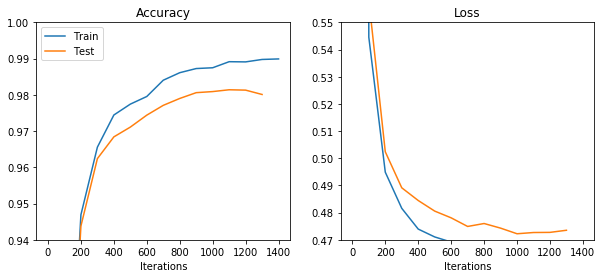

Average final accuracy: 0.9801
Average final loss: 0.473511


In [27]:
train_data_iterator = mnist_siamese_dataset_iterator(5000, 'train')
main_final0(200001)

Above plot shows the result of overfitting, caused by large batch size. Hence, I will reduce the batch size.

Extracting ./datasets/mnist/train-images-idx3-ubyte.gz
Extracting ./datasets/mnist/train-labels-idx1-ubyte.gz
Extracting ./datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting ./datasets/mnist/t10k-labels-idx1-ubyte.gz
Early stopping!


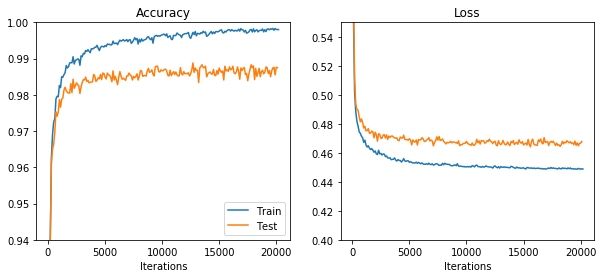

Average final accuracy: 0.9875
Average final loss: 0.467809


In [10]:
train_data_iterator = mnist_siamese_dataset_iterator(2000, 'train')
main_final0(200001)

Extracting ./datasets/mnist/train-images-idx3-ubyte.gz
Extracting ./datasets/mnist/train-labels-idx1-ubyte.gz
Extracting ./datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting ./datasets/mnist/t10k-labels-idx1-ubyte.gz
Early stopping!


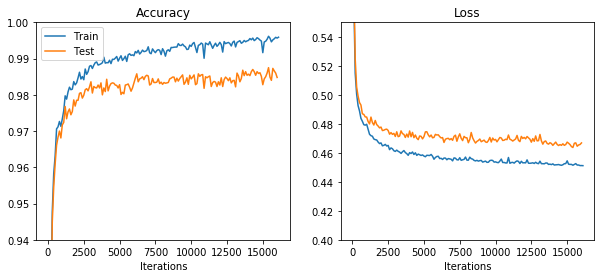

Average final accuracy: 0.9848
Average final loss: 0.466829


In [31]:
train_data_iterator = mnist_siamese_dataset_iterator(1000, 'train')
main_final0(200001)

As you can see 2000 batch offers the best result, due to its good balance btw sample size and overfitting.

With patience of 300 iterations, the algorithm ran into early stopping at ~19000 iterations.

Even though it gets ~0.96 accuracy at 1000th iteration. I will choose to run the training for 5000 iteration, because after that point, the difference between train loss and test loss, increase. Even though it hasn't start overfitting (testing error doesn't increase), but further training will yield smaller and smaller benefit.

## 3.2.11 Final hyperparameters
#### Distance function:
Logits are magnified by factor of 4
#### Regularization
L2 regularization is not used here.
#### Optimizer
Adam opimizer with epsilon set to 0.01, and learning rate of 0.15.
#### Activation function
Leaky Relu with negative slope of 0.001
#### Architeture
3-layer network with 256,128 and 32 neurons respectively. 20% dropout.
#### Initialization
Biases use Gaussian distribution with mean=0.3 and std=0.0001. Weights use uniform distribution.
#### Batch size
Batch size of 2000 is used.
#### Iterations
Use early stopping with 300 iteration patience setting.

## Part 4: Visualize learned features
(25 points)

Once a neural network is trained, we can think of the last layer as performing prediction, and the activations from layer before  become the input "features" to the predictor. If the neural network is performing good predictions, then this means that these activations encode useful features that are 1) representative of the input, and 2) discriminative for the prediction task. Activations at a selected layer could then be used as generic feature encodings of the input. 

We  expect a "good" feature encoding scheme to group similar inputs together in the feature encoding space. To check that, we can visualize the features in 2-dimensional space and check if similar examples (in this case, sharing the same labels) are close together. 

Tasks:

1. In TensorFlow, extract 32-dimensional features from the **distance layer** of your trained Siamese network, for the MNIST **test set**.
2. Reduce the dimensionality of your deep features to 2 using [t-SNE embedding](https://lvdmaaten.github.io/tsne/). You may use [this fast implementation](https://github.com/lvdmaaten/bhtsne/) with correct attribution. You could alternatively use [sklearn.manifold.TSNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html), but please take note that it might be slow.
3. Visualize the 2-dimensional embeddings. If your extracted features are good, data points representing a specific digit should appear within a compact cluster. In the example below, each color corresponds to a digit class.

 <img src="tsne.png" style="width:480px;">
 
For this part, the starter code is in minimalist fashion. Good luck!

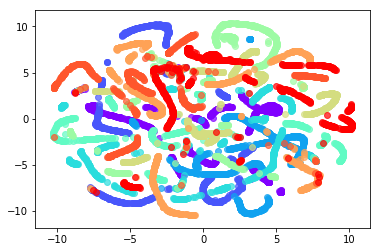

In [73]:
x = pickle.load(open('x_test.p','rb'))
y = pickle.load(open('y_test.p','rb'))

# Two dimension t-SNE
colors = cm.rainbow(np.linspace(0, 1, 10))
model = TSNE(n_components=2)
x1=model.fit_transform(x)
pickle.dump(x1,open('x1.p','wb'))
y1 = np.array(np.argmax(y,axis=1))
pickle.dump(y1,open('y1.p','wb'))

x1 = pickle.load(open('x1.p','rb'))
y1 = pickle.load(open('y1.p','rb'))
for k in range(10):
    plt.scatter(x1[y1==k,0],x1[y1==k,1],c=colors[k,:],alpha=0.7)
plt.show()

__For some reason, When I used t-SNE by itself, the result is not good (above). Since t-SNE is based on manifold learning, it learns lines in the embeded space. Therefore, I altered the vistualization a bit by implementing PCA initialization on the 32-dimension data.__

In [12]:
x = pickle.load(open('x_test.p','rb'))
y = pickle.load(open('y_test.p','rb'))

# Two dimension t-SNE
model = TSNE(n_components=2, n_iter=1000, learning_rate=400, perplexity=10, init='pca')
# model = TSNE(n_components=2, n_iter=200, learning_rate=1000, perplexity=50, init='pca')
x1=model.fit_transform(x)
pickle.dump(x1,open('x1.p','wb'))
y1 = np.array(np.argmax(y,axis=1))
pickle.dump(y1,open('y1.p','wb'))

### Seperated view

Two dimension t-SNE with PCA


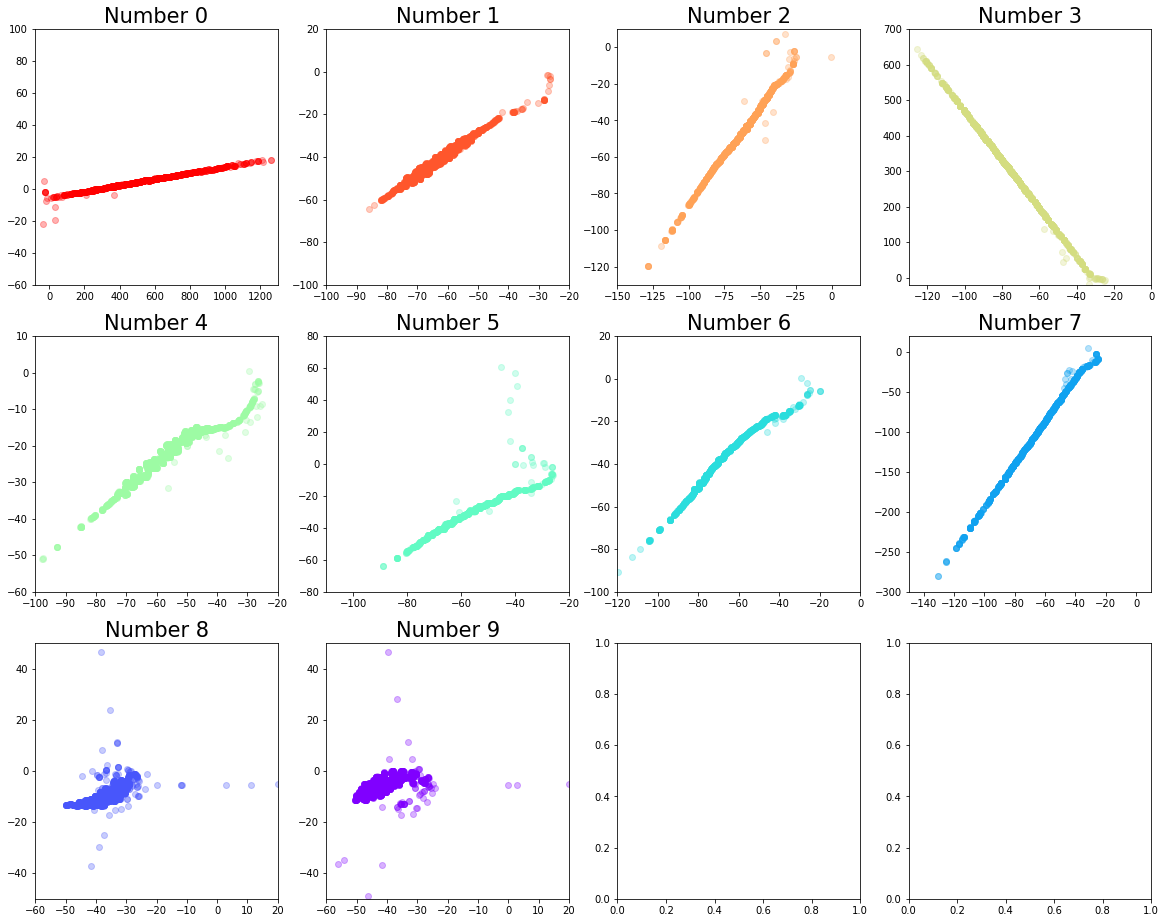

In [53]:
x1 = pickle.load(open('x1.p','rb'))
y1 = pickle.load(open('y1.p','rb'))
print('Two dimension t-SNE with PCA')
colors = cm.rainbow(np.linspace(1, 0, 10))
fig,axe = plt.subplots(3,4,figsize=(20,16))
axe[0,0].scatter(x1[y1==0,0],x1[y1==0,1],c=colors[0,:],alpha=0.3)
axe[0,0].set_ylim(-60,100)
axe[0,0].set_xlim(-80,1300)
axe[0,0].set_title('Number 0',fontsize=21)
axe[0,1].scatter(x1[y1==1,0],x1[y1==1,1],c=colors[1,:],alpha=0.3)
axe[0,1].set_ylim(-100,20)
axe[0,1].set_xlim(-100,-20)
axe[0,1].set_title('Number 1',fontsize=21)
axe[0,2].scatter(x1[y1==2,0],x1[y1==2,1],c=colors[2,:],alpha=0.3)
axe[0,2].set_ylim(-130,10)
axe[0,2].set_xlim(-150,20)
axe[0,2].set_title('Number 2',fontsize=21)
axe[0,3].scatter(x1[y1==3,0],x1[y1==3,1],c=colors[3,:],alpha=0.3)
axe[0,3].set_ylim(-20,700)
axe[0,3].set_xlim(-130,0)
axe[0,3].set_title('Number 3',fontsize=21)
axe[1,0].scatter(x1[y1==4,0],x1[y1==4,1],c=colors[4,:],alpha=0.3)
axe[1,0].set_ylim(-60,10)
axe[1,0].set_xlim(-100,-20)
axe[1,0].set_title('Number 4',fontsize=21)
axe[1,1].scatter(x1[y1==5,0],x1[y1==5,1],c=colors[5,:],alpha=0.3)
axe[1,1].set_ylim(-80,80)
axe[1,1].set_xlim(-110,-20)
axe[1,1].set_title('Number 5',fontsize=21)
axe[1,2].scatter(x1[y1==6,0],x1[y1==6,1],c=colors[6,:],alpha=0.3)
axe[1,2].set_ylim(-100,20)
axe[1,2].set_xlim(-120,0)
axe[1,2].set_title('Number 6',fontsize=21)
axe[1,3].scatter(x1[y1==7,0],x1[y1==7,1],c=colors[7,:],alpha=0.3)
axe[1,3].set_ylim(-300,20)
axe[1,3].set_xlim(-150,10)
axe[1,3].set_title('Number 7',fontsize=21)
axe[2,0].scatter(x1[y1==8,0],x1[y1==8,1],c=colors[8,:],alpha=0.3)
axe[2,0].set_ylim(-50,50)
axe[2,0].set_xlim(-60,20)
axe[2,0].set_title('Number 8',fontsize=21)
axe[2,1].scatter(x1[y1==9,0],x1[y1==9,1],c=colors[9,:],alpha=0.3)
axe[2,1].set_ylim(-50,50)
axe[2,1].set_xlim(-60,20)
axe[2,1].set_title('Number 9',fontsize=21)
plt.show()

### Combined view

Two dimension t-SNE with PCA


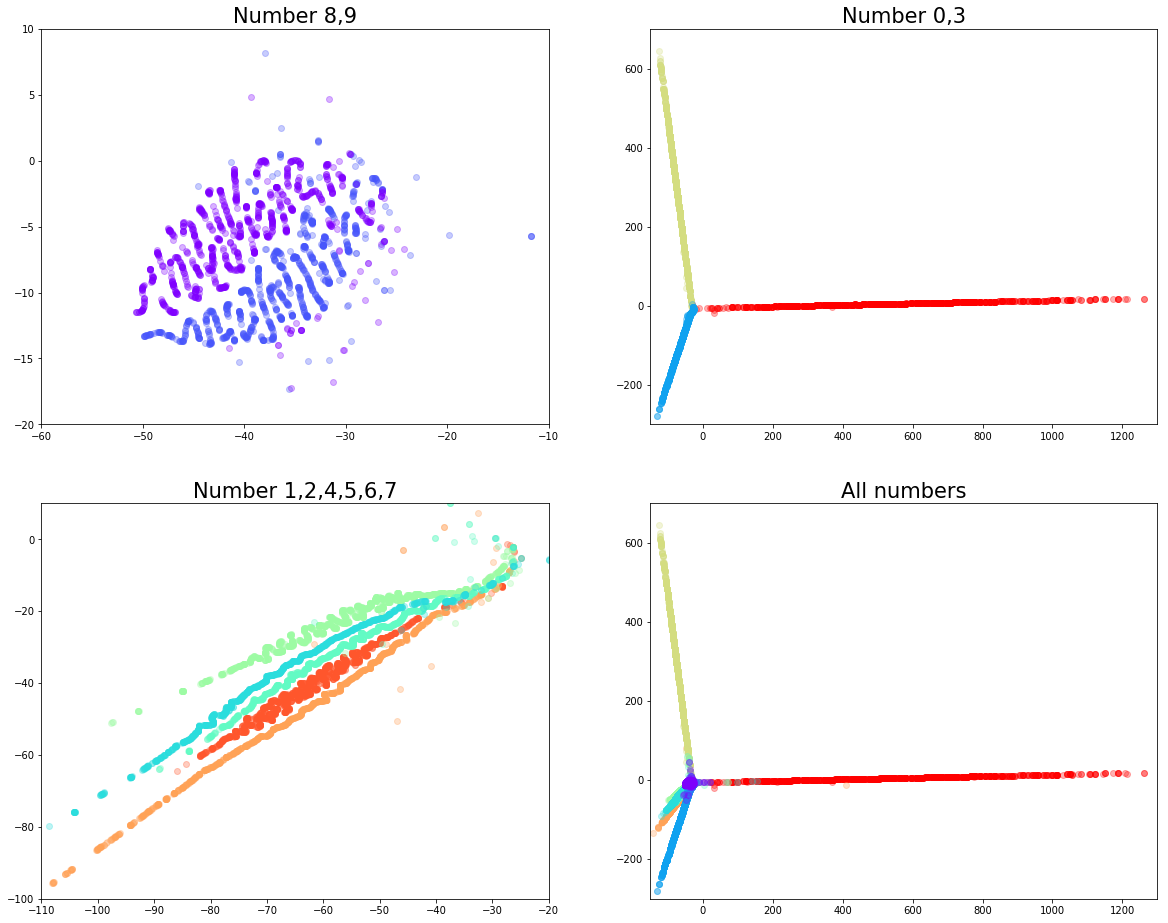

In [29]:
x1 = pickle.load(open('x1.p','rb'))
y1 = pickle.load(open('y1.p','rb'))
print('Two dimension t-SNE with PCA')
colors = cm.rainbow(np.linspace(1, 0, 10))
fig,axe = plt.subplots(2,2,figsize=(20,16))
axe[0,0].scatter(x1[y1==8,0],x1[y1==8,1],c=colors[8,:],alpha=0.3)
axe[0,0].scatter(x1[y1==9,0],x1[y1==9,1],c=colors[9,:],alpha=0.3)
axe[0,0].set_ylim(-20,10)
axe[0,0].set_xlim(-60,-10)
axe[0,0].set_title('Number 8,9',fontsize=21)
axe[1,0].scatter(x1[y1==1,0],x1[y1==1,1],c=colors[1,:],alpha=0.3)
axe[1,0].scatter(x1[y1==2,0],x1[y1==2,1],c=colors[2,:],alpha=0.3)
axe[1,0].scatter(x1[y1==4,0],x1[y1==4,1],c=colors[4,:],alpha=0.3)
axe[1,0].scatter(x1[y1==5,0],x1[y1==5,1],c=colors[5,:],alpha=0.3)
axe[1,0].scatter(x1[y1==6,0],x1[y1==6,1],c=colors[6,:],alpha=0.3)
axe[1,0].set_ylim(-100,10)
axe[1,0].set_xlim(-110,-20)
axe[1,0].set_title('Number 1,2,4,5,6,7',fontsize=21)
axe[0,1].scatter(x1[y1==0,0],x1[y1==0,1],c=colors[0,:],alpha=0.3)
axe[0,1].scatter(x1[y1==3,0],x1[y1==3,1],c=colors[3,:],alpha=0.3)
axe[0,1].scatter(x1[y1==7,0],x1[y1==7,1],c=colors[7,:],alpha=0.3)
axe[0,1].set_ylim(-300,700)
axe[0,1].set_xlim(-150,1300)
axe[0,1].set_title('Number 0,3',fontsize=21)
for k in range(10):
    axe[1,1].scatter(x1[y1==k,0],x1[y1==k,1],c=colors[k,:],alpha=0.3)
axe[1,1].set_ylim(-300,700)
axe[1,1].set_xlim(-150,1300)
axe[1,1].set_title('All numbers',fontsize=21)
plt.show()

Plots shows quite clear seperations between 10 clusters, despite that there are four cluster are straight line shaped.

8 and 9 are very close to each other, which makes sense.

## Part5: Using Keras to implement Siamese network

In [5]:
import numpy as np

import random
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Lambda, advanced_activations
from keras.optimizers import Adam
from keras import backend as K

In [8]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

def create_pairs(x, digit_indices):
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(10)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(10)]
te_pairs, te_y = create_pairs(x_test, digit_indices)

In [39]:
def cos_sim(vects):
    x, y = vects
    return K.mean(K.l2_normalize(x,1) * K.l2_normalize(y,1), keepdims=True)


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def network(input_dim):
    model = Sequential()
    model.add(Dense(256, input_dim=input_dim))
    model.add(advanced_activations.LeakyReLU(alpha=0.01))
    model.add(Dropout(0.2))
    model.add(Dense(128))
    model.add(advanced_activations.LeakyReLU(alpha=0.01))
    model.add(Dense(32))
    return model

def compute_accuracy(predictions, labels):
    return labels[predictions.ravel() < 0.5].mean()

input_dim = 784
epochs = 1

base_network = network(input_dim)

input_a = Input(shape=(input_dim,))
input_b = Input(shape=(input_dim,))

processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(cos_sim, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

model.compile(loss='binary_crossentropy', optimizer=Adam(epsilon=0.01))
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y),
          batch_size=100,
          epochs=epochs)

# compute final accuracy on training and test sets
pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
compute_accuracy(pred, te_y)

Train on 108400 samples, validate on 17820 samples
Epoch 1/1
108400/108400 [==============================] - 6s - loss: 1.7604 - val_loss: 1.7496


0.5